# Perturbation Tracers

We measure tracers of the (tidal) perturbations on each OC, spatial and dynamical.

- Compression along X,Y and Z
- Virial proxy
- velocity dispersion markers
- "halo" excess (tidal loss)
- TBD

In [122]:
using PyCall
using Statistics , MultivariateStats
using Printf
import PyPlot , CSV , Distances

sns= pyimport("seaborn")

rootdir = ENV["GAIA_ROOT"]
push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

#Constants
const G= 4.30091e-3   #[solar mass][pc][km/s]

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/plots"
ocdir= "$wdir/oc2"

cd(wdir)

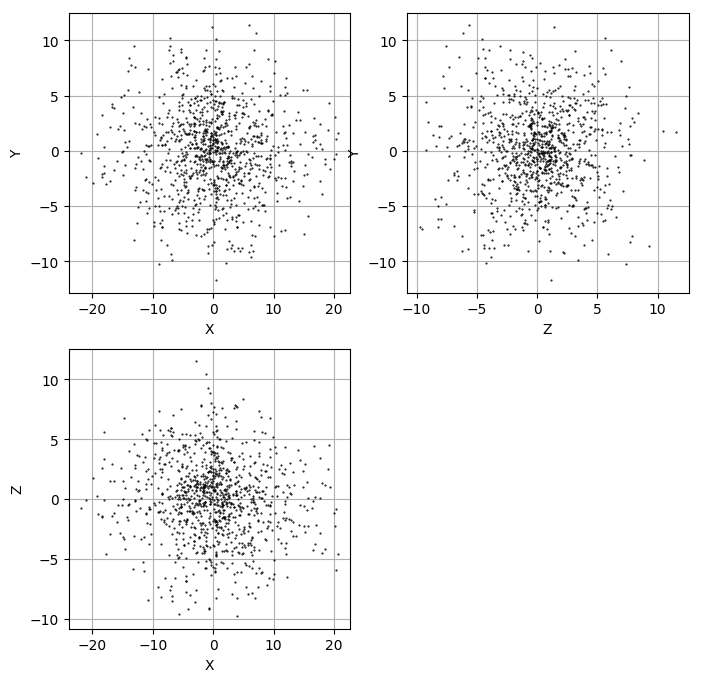

In [123]:
## Reading the test OC

ocname= "$ocdir/NGC 6025-1.7deg-oc.csv"
ocname= "$ocdir/NGC 2516-3.5deg-oc-mass.csv"
ocname= "$ocdir/NGC 2632-15.5deg-oc-mass.csv"

oc= CSV.read(ocname, delim= ";")

## OC recentered
oc.X= oc.X .- mean(oc.X)
oc.Y= oc.Y .- mean(oc.Y)
oc.Z= oc.Z .- mean(oc.Z)

fig= PyPlot.figure(figsize=(8,8))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(oc.X, oc.Y,"k.",markersize=1)
PyPlot.xlabel("X") ; PyPlot.ylabel("Y")
ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.plot(oc.Z, oc.Y,"k.", markersize=1)
PyPlot.xlabel("Z") ; PyPlot.ylabel("Y")
ax= PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.plot(oc.X, oc.Z,"k.",markersize=1)
PyPlot.xlabel("X") ; PyPlot.ylabel("Z")

PyPlot.show()

## XYZ markers

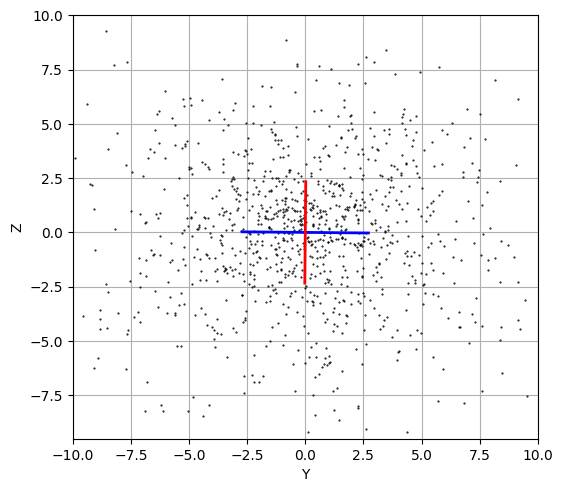

## Using PCA on XYZ to estimate the ellipsoid shape
##
[0.9985922940877225 0.021426951384036497 0.04852129370704293; -0.020972697368524917 0.9997315074800507 -0.009851848392741787; -0.04871936117917851 0.00882035747866534 0.9987735604931888]
[7.054235663984289, 3.8375951607810217, 3.3002093371690147]
## Axis ratio with PC[3]
[2.1375115767763853, 1.1628338595251013, 1.0]


In [124]:
data= convert(Matrix, oc[:,8:10])

println("## Using PCA on XYZ to estimate the ellipsoid shape")
println("##")

M = fit(PCA, data')
## dump(M)
prat= principalratio(M)

pvars= principalvars(M)
pdisp= sqrt.(pvars)
proj= projection(M)
println(proj)
println(pdisp)
## Axis ratio
println("## Axis ratio with PC[3]")
println(sqrt.(pvars)./sqrt(pvars[3]))

x1= proj[2,2] ; y1= proj[2,3]
x2= proj[3,2] ; y2= proj[3,3]


x1d= x1 * pdisp[2] / sqrt(2*(x1^2 + y1^2)) ; y1d= y1 * pdisp[2] / sqrt(2*(x1^2 + y1^2))
x2d= x2 * pdisp[3] / sqrt(2*(x2^2 + y2^2)) ; y2d= y2 * pdisp[3] / sqrt(2*(x2^2 + y2^2))

fig= PyPlot.figure(figsize=(6,5.5))
ax= PyPlot.subplot(111)
PyPlot.xlim(-10,10) ; PyPlot.ylim(-9.5,10) ;
PyPlot.grid("on")
PyPlot.plot(oc.Y, oc.Z,"k.",  lw=0.1,markersize=1)
PyPlot.plot((-x1d,x1d),(-y1d,y1d),"b-", lw=2)
PyPlot.plot((-x2d,x2d),(-y2d,y2d),"r-", lw=2)

PyPlot.xlabel("Y") ; PyPlot.ylabel("Z")
PyPlot.show()

In [125]:
println("## Compute XYZ σ dispersion")
println("## ratio are taken wrt. Z")

σx= std(oc.X) ; σy= std(oc.Y) ; σz= std(oc.Z)
kx = σx / σz ; ky= σy / σz

@printf("### σx=%3.3f , σy=%3.3f , σz=%3.3f \n", σx, σy, σz)
@printf("### ratio kx=%3.3f , ky=%3.3f , kz=1.0 \n",kx,ky)

## Compute XYZ σ dispersion
## ratio are taken wrt. Z
### σx=7.047 , σy=3.840 , σz=3.314 
### ratio kx=2.126 , ky=1.159 , kz=1.0 


## Velocity markers

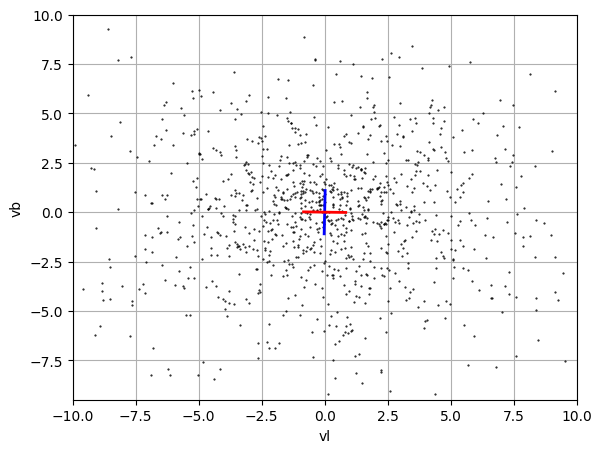

## Compute the PCA of the vl,vb velocities
## Using PCA on vl/vb to estimate the  velocity ellipsoid shape
##
[-0.017939947087025357 -0.9998390661994133; 0.9998390661994133 -0.017939947087025357]
[1.5512960962730205, 1.1848048411656564]
## Axis ratio with PC[2]
[1.309326264017284, 1.0]


In [126]:
println("## Compute the PCA of the vl,vb velocities")

datav= convert(Matrix, oc[:,11:12])

println("## Using PCA on vl/vb to estimate the  velocity ellipsoid shape")
println("##")

M = fit(PCA, datav')
## dump(M)
prat= principalratio(M)

pvars= principalvars(M)
pdisp= sqrt.(pvars)
proj= projection(M)
println(proj)
println(pdisp)
## Axis ratio
println("## Axis ratio with PC[2]")
println(sqrt.(pvars)./sqrt(pvars[2]))

x1= proj[1,1] ; y1= proj[1,2]
x2= proj[2,1] ; y2= proj[2,2]


x1d= x1 * pdisp[1] / sqrt(2*(x1^2 + y1^2)) ; y1d= y1 * pdisp[1] / sqrt(2*(x1^2 + y1^2))
x2d= x2 * pdisp[2] / sqrt(2*(x2^2 + y2^2)) ; y2d= y2 * pdisp[2] / sqrt(2*(x2^2 + y2^2))


fig= PyPlot.figure(figsize=(6.5,5))
ax= PyPlot.subplot(111)
PyPlot.xlim(-10,10) ; PyPlot.ylim(-9.5,10) ;
PyPlot.grid("on")
PyPlot.plot(oc.Y, oc.Z,"k.",  lw=0.1, markersize=1)
PyPlot.plot((-x1d,x1d),(-y1d,y1d),"b-", lw=2)
PyPlot.plot((-x2d,x2d),(-y2d,y2d),"r-", lw=2)

PyPlot.xlabel("vl") ; PyPlot.ylabel("vb")
PyPlot.show()


In [127]:
println("## Compute Vl Vb σ dispersion")
println("## ratio are taken wrt. Vb")

σvl= std(oc.vl) ; σvb= std(oc.vb) 
kvl = σvl / σvb 

@printf("### σvl=%3.3f , σvb=%3.3f \n", σvl, σvb)
@printf("### ratio kvl=%3.3f",kvl)

## Compute Vl Vb σ dispersion
## ratio are taken wrt. Vb
### σvl=1.185 , σvb=1.551 
### ratio kvl=0.764

## Projected Virial YZ

Estimation of the projected virial using m,y,z,vl,vb of the stars.


In [128]:
## Functions

function virial_2d(mass,x,y,vx,vy)
    nstars= length(mass)
    
    A= Array{Float64}(undef,2,nstars)
    for i in 1:nstars
        A[:,i]= [x[i] y[i]]
    end
    
    d= Distances.Euclidean()
    p= Distances.pairwise(d, A, A, dims=2)
    
    ## potential energy
    Ω= 0.
    for i in 1:nstars
        for j in 1:nstars
            if i!=j
                Ω+= -G * mass[i] * mass[j] / p[i,j]
            end
        end
    end
    
    ## kinetic energy
    T= 0.
    for i in 1:nstars
        T+= 0.5 * mass[i] * (vx[i]^2 + vy[i]^2)
    end
    
    ## Virial
    vir= 2T+Ω
    
    return(vir, T, Ω)
end

virial_2d (generic function with 1 method)

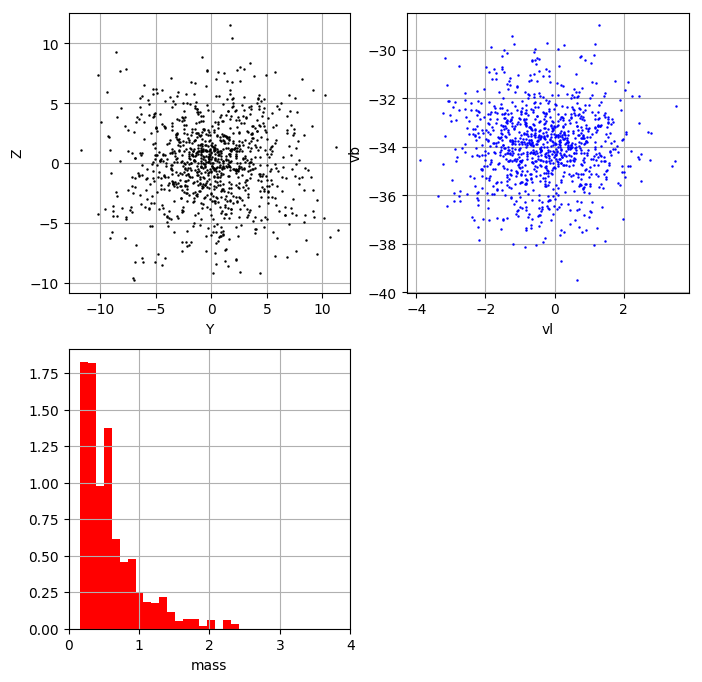

In [129]:
# oc csv file with estimated mass.
ocname= "NGC 6025-1.7deg-oc-mass.csv"
ocname= "NGC 2516-3.5deg-oc-mass.csv"
ocname= "NGC 2632-15.5deg-oc-mass.csv"
ocm= CSV.read("$ocdir/$ocname", delim=";")

## OC recentered
ocm.X= ocm.X .- mean(ocm.X)
ocm.Y= ocm.Y .- mean(ocm.Y)
ocm.Z= ocm.Z .- mean(ocm.Z)

fig= PyPlot.figure(figsize=(8,8))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(ocm.Y, ocm.Z,"k.", markersize= 1.5)
PyPlot.xlabel("Y") ; PyPlot.ylabel("Z")
ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.plot(ocm.vl, ocm.vb,"b.",markersize= 1.5 )
PyPlot.xlabel("vl") ; PyPlot.ylabel("vb")
ax= PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.xlim([0,4])
PyPlot.hist(ocm.mass , 20, density=true, facecolor="r")
PyPlot.xlabel("mass") 


PyPlot.show()

In [130]:
## Virial computation
# we need to center the velocity
vlcentered= ocm.vl .- mean(ocm.vl)
vbcentered= ocm.vb .- mean(ocm.vb)

vir, T, V= virial_2d(ocm.mass, ocm.Y, ocm.Z, vlcentered, vbcentered)
@printf("## Virial= %3.3f , T= %3.3f , V= %3.3f", vir, T, V)

## Virial= 1479.363 , T= 977.955 , V= -476.547

## Phase-Space diagram.

Tests to plot phase-space diagram

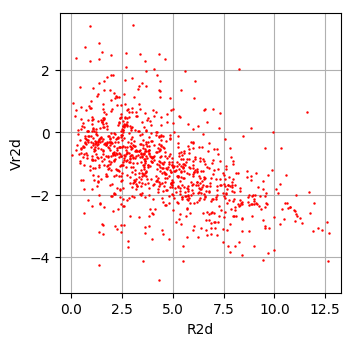

In [131]:
# plot of the YZ Vrad/Rad
## OC Vrecentered
ocm.vl= ocm.vl .- mean(ocm.vl)
ocm.vb= ocm.vb .- mean(ocm.vb)

vrad2d= (ocm.vl .* ocm.Y .+ ocm.vb .* ocm.Z) ./ sqrt.(ocm.Y .* ocm.Y .+ ocm.Z .* ocm.Z)
rad2d= sqrt.(ocm.Y .* ocm.Y .+ ocm.Z .* ocm.Z)


fig= PyPlot.figure(figsize=(8,8))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(rad2d, vrad2d,"r.", markersize= 1.5)
PyPlot.xlabel("R2d") ; PyPlot.ylabel("Vr2d")
PyPlot.show()

## Perturbation map

Perturbation map of the 2D density using the Cauchy fit

In [132]:
# Cauchy fit
#
# Best solution

C= 36.367  ; s= 6.154  ; m=  2.855 
C= 16.944 ; s= 6.633  ;m= 3.260
θ= modelCauchy(C,s,m)


modelCauchy(16.944, 6.633, 3.26)

In [133]:
## density 2d

function _dens2d(x,y, xyrange=[-1,1], nbin=10)
    dens= zeros(Float64,nbin,nbin)
    dl= (xyrange[2]-xyrange[1]) / nbin
    
    for i in 1:length(x)
        ix= convert(Int,floor((x[i]-xyrange[1])/dl+0.5))
        iy= convert(Int,floor((y[i]-xyrange[1])/dl+0.5))
        
        if ix>0 && ix<=nbin && iy>0 && iy<=nbin
            dens[ix,iy]+=1.0
        end
    end
    
    dS= dl*dl
    dens= dens ./ dS
    
    return(dens)
end

function _dens_pert(dens2d,xyrange, θ, fdens::Function)
    s=size(dens2d)
    nbin=s[1]
    if s[1] != s[2]
        println("## Warning, not a square density image")
    end
    dl= (xyrange[2]-xyrange[1]) / nbin
    pert2d= copy(dens2d)
    s=size(dens2d)
    
    for i in 1:s[1]
        for j in 1:s[2]
            xx= (i-0.5)*dl+xyrange[1]
            yy= (j-0.5)*dl+xyrange[1]
            
            rr= sqrt(xx*xx+yy*yy)
            dmodel= fdens(rr, θ)
            pert2d[i,j]-=dmodel
            
        end
    end
    
    return(pert2d)
end

_dens_pert (generic function with 1 method)

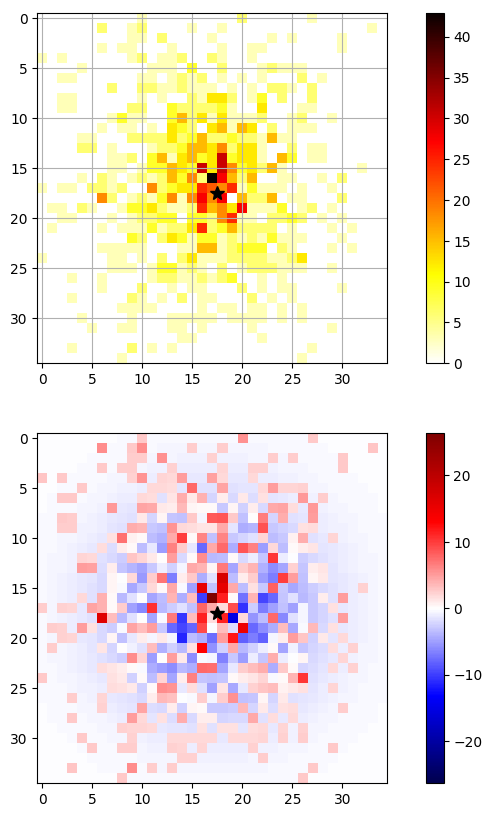

In [158]:
lrange=[-10,10]
dens= _dens2d(ocm.Y,ocm.Z,lrange,35)
pert= _dens_pert(dens,lrange,θ, fdens1)
xcenter= size(pert)[1]/2 ;ycenter= xcenter

fig= PyPlot.figure(figsize=(10,10))
ax1= PyPlot.subplot(211)
PyPlot.grid("on")
pos= PyPlot.imshow(dens, cmap="hot_r", interpolation= "nearest")
PyPlot.plot(xcenter,ycenter,"k*", markersize=10, lw=2)
fig.colorbar(pos, ax=ax1)


vmin= - max(maximum(pert), abs(minimum(pert)))
vmax= -vmin
ax2= PyPlot.subplot(212)
pos= PyPlot.imshow(pert, cmap="seismic", vmin=vmin,vmax=vmax ,interpolation= "nearest")
PyPlot.plot(xcenter,ycenter,"k*", markersize=10, lw=2)
fig.colorbar(pos, ax=ax2)


PyPlot.show()